## The optimal composition of the portfolio

### Vol 2

#### 26.04.2019

In [1]:
# connection necessary packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

## Helpfull function

In [51]:
# profitability of the portfolio
def port_mean(d, means, n_days=250):
    d = np.array(d)
    return np.sum(means * d) * n_days


# volatility of the portfolio
def port_vol(d, cov, n_days=250):
    d = np.array(d)
    return np.sqrt(np.dot(d.T, np.dot(cov * n_days, d)))


# Vallue at Risk (VaR) of asset
def asset_VaR(df, alpha = 5):
    var = []
    col = list(df.columns)
    for i in col:
        num = sorted(list(df[i]))
        var.append(-np.percentile(num, 5))
    return var


# Portfolio Value at Risk 
def port_VaR(weights, var):
    a = np.array(weights)
    b = np.array(var)
    return np.dot(a, b)


# Flag
def flag(df, n_assets):
    df['Flag'] = 1
    for i in range(1, len(df.index)):
        b = i - 1
        if df.index.year[i] == df.index.year[b]:
            df.iloc[i, n_assets] = 0

        

# filter dataframe
def filter_df(df, start, stop):
        df = df[df.index >= start]
        df = df[df.index <= stop]
        return df

    
# portfolio characteristic
def char(weight, df):
    start = ''
    stop = str(df.index[len(df.index)-1])[:10]
    n = int(0)
    share = 1
    res = []
    for i in df['Flag']:
        if i == 1:
            n += 1
            start = str(df.index[n-1])[:10]
            temp = filter_df(df, start, stop)
            del temp['Flag']
            means = port_mean(weight, np.mean(temp), n_days = len(temp.index))
            vol = port_vol(weight, np.cov(temp, rowvar = False), n_days = len(temp.index))
            res.append(means / vol)
        else:
            n += 1
    return -sum(res)

# assets characteristic
def assets_char(df):
    df[len(df['Flag']) - 1, n_assets] = 1
    start = str(df.index[0])[:10]
    stop = ''
    n = int(0)
    share = 1
    iret = []
    bret = []
    ivol = []
    bvol = []
    cov = []
    num = sum(df['Flag'])
    for i in df['Flag']:
        if i == 1:
            if n == 0:
                continue
            n += 1
            stop = str(df.index[n-1])[:10]
            temp = filter_df(df, start, stop)
            del temp['Flag']
            means = np.mean(temp)
            vol = np.std(temp)
            iret.append(means[0] * (len(temp.index)))
            bret.append(means[1] * (len(temp.index)))
            ivol.append(vol[0] * (np.sqrt(len(temp.index))))
            bvol.append(vol[1] * (np.sqrt(len(temp.index))))
            cov.append(np.cov(temp, rowvar = False)[0][1])
            num -= 1
        else:
            n += 1
            if stop != '':
                start = stop
    return iret, bret, ivol, bvol, cov

In [3]:
# data parse
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
# download and calculate data
index = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/MOEXBC_c.csv'
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
bond = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Diploma/master/MAIN_DATA/RGBITR_c.csv '
                    , header=0, index_col=0, parse_dates={'Index_Date': [0]}, date_parser=dateparse, sep=';')
temp = ['OPEN', 'HIGH', 'LOW', 'VALUE', 'DURATION', 'YIELD', 'DECIMALS', 'CAPITALIZATION', 'CURRENCYID', 'DIVISOR']
for i in temp:
    del index[i]
    del bond[i]
n_assets = 2
# index = index[index.index >= '2014-01-01']
# bond = bond[bond.index >= '2014-01-01']

In [4]:
# get daily returns
main = pd.merge(index, bond, left_index = True, right_index = True)
main = main.apply(lambda x: np.log(x / x.shift(1)))
main.dropna(inplace = True)
main.columns = ['Blue Chips', 'Bond index']
main.index.name = 'Date'
main.head()

,Blue Chips,Bond index
Date,,
2012-04-03,0.018686,0.000211
2012-04-04,-0.023290,-0.000986
2012-04-05,0.008678,0.000141
2012-04-06,-0.018159,-0.000564
2012-04-09,0.007753,-0.001129


In [5]:
means = np.mean(main.iloc[:, :n_assets])
means

Blue Chips    0.000292
Bond index    0.000316
dtype: float64

In [6]:
cov = np.cov(main.iloc[:, :n_assets], rowvar = False)
cov

array([[1.37640789e-04, 9.46097582e-06],
       [9.46097582e-06, 1.85913110e-05]])

In [7]:
var = asset_VaR(main.iloc[:, :n_assets])
var

[0.017654779404523115, 0.004752309651628121]

In [8]:
flag(main, n_assets)
main.head()

,Blue Chips,Bond index,Flag
Date,,,
2012-04-03,0.018686,0.000211,1
2012-04-04,-0.023290,-0.000986,0
2012-04-05,0.008678,0.000141,0
2012-04-06,-0.018159,-0.000564,0
2012-04-09,0.007753,-0.001129,0


## Maximizes the total difference between return and risk

In [9]:
z = len(main.index)
# portfolio with equal weights on all assets
w_initial = n_assets*[1./n_assets]
# the restriction weights of the assets
bnds = tuple((0, 1) for x in range(n_assets))
# restriction - the sum of weights should not exceed one
cons=({'type':'eq','fun':lambda x:sum(x)-1})
# portfolio with maximum differnt between return and risk
min_diff = sco.minimize(char, w_initial, (main), method = 'SLSQP', bounds = bnds, constraints = cons)
print('Weights of portfolio with maximum differnt between return and risk:',*min_diff['x'].round(4))

Weights of portfolio with maximum differnt between return and risk: 0.0483 0.9517


In [10]:
# min_diff = pd.DataFrame()
# min_diff['x'] = [0.0441, 0.9559]

In [11]:
'Year return: ' + str(round(port_mean(min_diff['x'], means) * 100, 5)) + '%'

'Year return: 7.86711%'

In [17]:
cov = np.cov(main.iloc[:, :n_assets], rowvar = False)
'Year risk: ' + str(round(port_vol(min_diff['x'], cov) * 100, 5)) + '%'

'Year risk: 6.71377%'

In [13]:
'Dayly VaR: ' + str(round(port_VaR(min_diff['x'], var) * 100, 5)) + '%'

'Dayly VaR: 0.53749%'

## Calculate all posible portfolio whit optimal portfolio

In [14]:
# take step by one year
time = range(8)
a = np.linspace(min_diff['x'][1], 1, len(time))
b = np.linspace(0, 1, len(time))

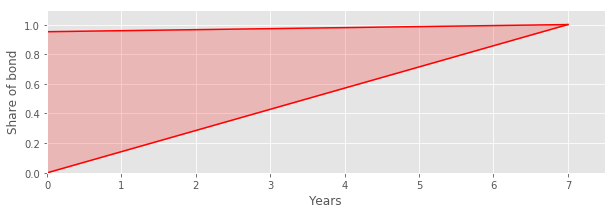

In [15]:
# set of asset portfolio
_=plt.figure(figsize = (10, 3))
_=plt.style.use('ggplot')
_=plt.plot(time, a, color = 'r', marker = '')
_=plt.plot(time, b, color = 'r', marker = '')
_=plt.fill_between(time, a, b, color = 'r', alpha = .2)
_=plt.ylabel('Share of bond')
_=plt.xlabel('Years')
_=plt.xlim(0, len(time) - .5)
_=plt.ylim(0, 1.1)

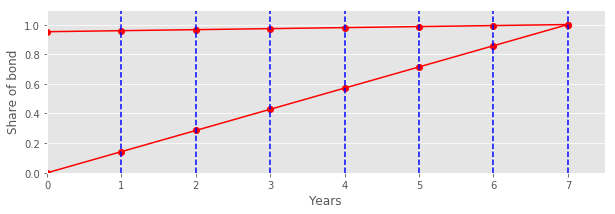

In [16]:
_=plt.figure(figsize = (10, 3))
_=plt.style.use('ggplot')
_=plt.plot(time, a, color = 'r', marker = 'o')
_=plt.plot(time, b, color = 'r', marker = 'o')
for i in range(1, len(time)):
    _=plt.axvline(x = i, color='b', linestyle='--')
_=plt.ylabel('Share of bond')
_=plt.xlabel('Years')
_=plt.xlim(0, len(time) - .5)
_=plt.ylim(0, 1.1)

In [52]:
ir, br, iv, bv, cov = assets_char(main)
port_min = pd.DataFrame({'Bond': a, 'Stocks': [1-i for i in a], 'Means_b': br, 'Means_s': ir,
                         'Vol_b': bv, 'Vol_s': iv, 'Cov': cov})
port_max = pd.DataFrame({'Bond': b, 'Stocks': [1-i for i in b], 'Means_b': br, 'Means_s': ir,
                         'Vol_b': bv, 'Vol_s': iv, 'Cov': cov})
col = ['Means_b', 'Means_s', 'Vol_b', 'Vol_s', 'Cov']

c:\python37-32\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
port_min['Rent'] = (port_min['Bond'] * port_min['Means_b']) + (port_min['Stocks'] * port_min['Means_s'])
port_min['Risk'] = (port_min['Bond']**2 * port_min['Vol_b']) + (port_min['Stocks']**2 * port_min['Vol_s']) + 2 * (port_min['Bond'] * port_min['Stocks'] * port_min['Cov'])
port_max['Rent'] = (port_max['Bond'] * port_max['Means_b']) + (port_max['Stocks'] * port_max['Means_s'])
port_max['Risk'] = (port_max['Bond']**2 * port_max['Vol_b']) + (port_max['Stocks']**2 * port_max['Vol_s']) + 2 * (port_max['Bond'] * port_max['Stocks'] * port_max['Cov'])

In [54]:
for i in col:
    del port_min[i]
    del port_max[i]

In [55]:
port_min = port_min.apply( lambda x: round(x, 4))
port_min['Rent'] = port_min['Rent'].apply(lambda x: str(round(x * 100, 4)) + '%')
port_min['Risk'] = port_min['Risk'].apply(lambda x: str(round(x * 100, 4)) + '%')

In [56]:
port_max = port_max.apply( lambda x: round(x, 4))
port_max['Rent'] = port_max['Rent'].apply(lambda x: str(round(x * 100, 4)) + '%')
port_max['Risk'] = port_max['Risk'].apply(lambda x: str(round(x * 100, 4)) + '%')

In [57]:
port_min

,Bond,Stocks,Rent,Risk
0,0.9517,0.0483,9.03%,2.35%
1,0.9586,0.0414,3.7%,4.65%
2,0.9655,0.0345,-15.13%,12.14%
3,0.9724,0.0276,26.02%,8.41%
4,0.9793,0.0207,14.16%,4.28%
5,0.9862,0.0138,11.79%,2.33%
6,0.9931,0.0069,2.24%,4.23%
7,1.0000,0.0000,4.42%,1.66%


In [58]:
port_max

,Bond,Stocks,Rent,Risk
0,0.0000,1.0000,-2.77%,16.46%
1,0.1429,0.8571,1.12%,11.66%
2,0.2857,0.7143,-10.42%,13.4%
3,0.4286,0.5714,22.36%,8.77%
4,0.5714,0.4286,18.02%,4.53%
5,0.7143,0.2857,6.83%,2.38%
6,0.8571,0.1429,3.96%,3.53%
7,1.0000,0.0000,4.42%,1.66%


### 50% Stocks and 50% Bonds

In [3]:
# take step by one year
time = range(5)
b = np.linspace(0.5, 1, len(time))

In [6]:
for i in b:
    print(i, end='|')
print()
for i in b:
    print(1- i, end='|')

0.5|0.625|0.75|0.875|1.0|
0.5|0.375|0.25|0.125|0.0|